### Load & Inspect Data

In [2]:
import pandas as pd
df = pd.read_csv('diabetes.csv')
print(df.head(), df.shape)
print(df.isnull().sum(), (df == 0).sum())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1   (768, 9)
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64 Pregnancies

### Clean Data (Handle Zeros as Missing)

In [3]:
cols_zero_na = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in cols_zero_na:
    df[col] = df[col].replace(0, pd.NA)
df = df.dropna()


### Data Visualization

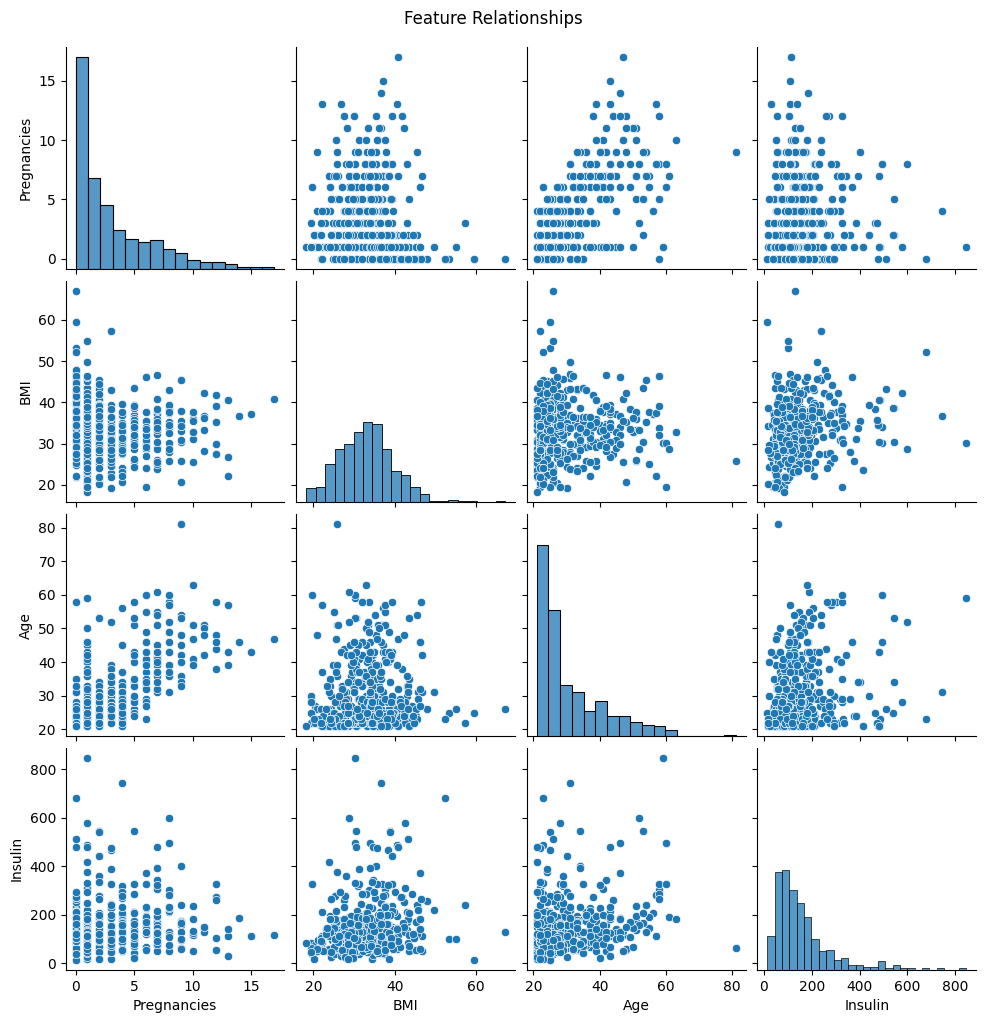

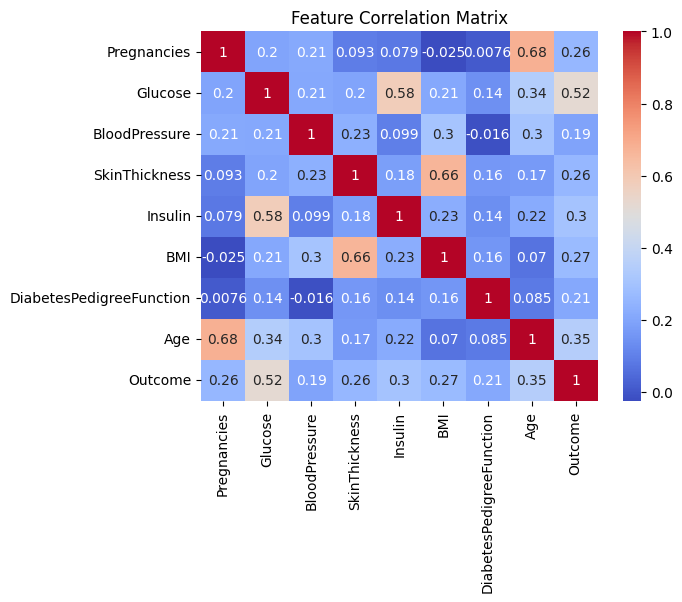

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[['Pregnancies','BMI','Age','Insulin']])
plt.suptitle('Feature Relationships', y=1.02)
plt.show()

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


### Select Features and Target

In [5]:
y = df['Insulin']
X = df.drop(columns=['Insulin','Outcome'])


### Split & Standardize Data

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Linear Regression (SGD)

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

sgd = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.01, random_state=42)
sgd.fit(X_train_scaled, y_train)
y_train_pred = sgd.predict(X_train_scaled)
y_test_pred = sgd.predict(X_test_scaled)

print('SGDRegressor → MSE train/test:', mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred))
print('R² test:', r2_score(y_test, y_test_pred))


SGDRegressor → MSE train/test: 9211.143194898135 8791.566464416455
R² test: 0.39247622030800644


### Manual Gradient Descent with Loss Curve

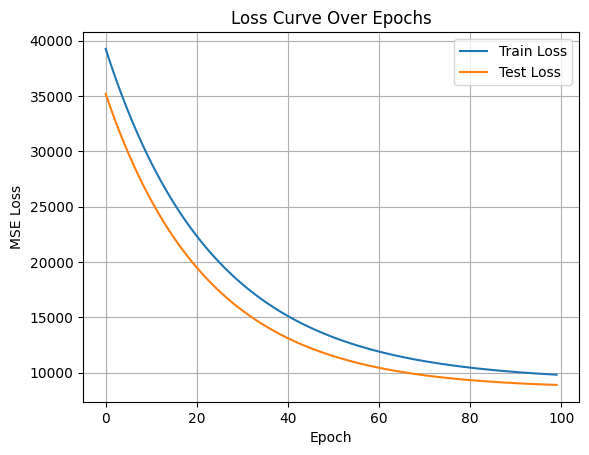

In [20]:
import numpy as np

X_train_np = np.array(X_train_scaled, dtype=np.float64)
X_test_np = np.array(X_test_scaled, dtype=np.float64)
y_train_np = y_train.values.astype(np.float64)
y_test_np = y_test.values.astype(np.float64)

w = np.zeros(X_train_np.shape[1])
b = 0.0
n_epochs = 100
alpha = 0.01
m = len(y_train_np)

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    y_pred = np.dot(X_train_np, w) + b
    error = y_pred - y_train_np
    loss = (error**2).mean()
    train_losses.append(loss)

    # test loss
    y_test_pred_manual = np.dot(X_test_np, w) + b
    test_loss = ((y_test_pred_manual - y_test_np)**2).mean()
    test_losses.append(test_loss)

    grad_w = (2/m) * np.dot(X_train_np.T, error)
    grad_b = (2/m) * error.sum()

    w -= alpha * grad_w
    b -= alpha * grad_b

plt.plot(range(n_epochs), train_losses, label='Train Loss')
plt.plot(range(n_epochs), test_losses, label='Test Loss')
plt.title('Loss Curve Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


### Before & After Scatter Plot

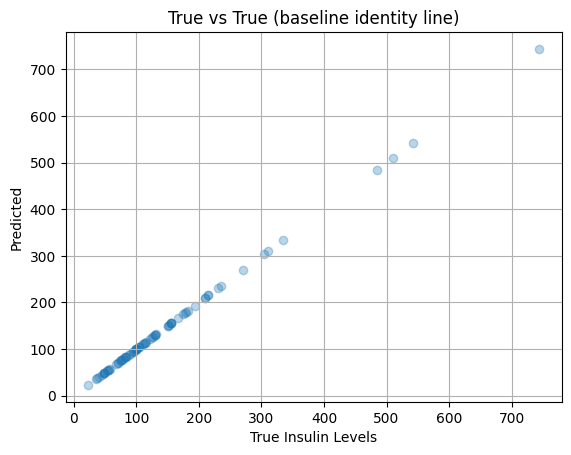

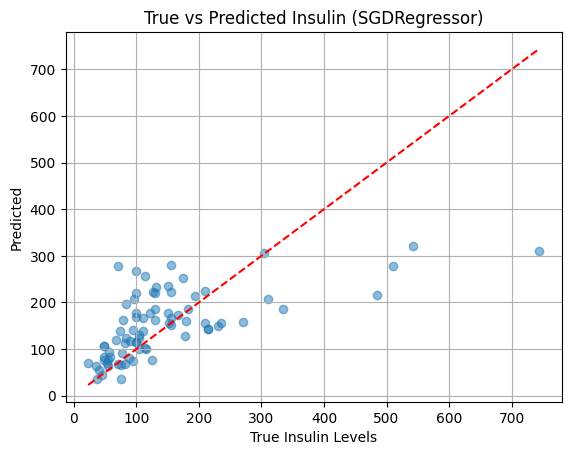

In [11]:
# Baseline plot
plt.scatter(y_test_np, y_test_np, label='Actual', alpha=0.3)
plt.title('True vs True (baseline identity line)')
plt.xlabel('True Insulin Levels')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

# After model prediction
plt.scatter(y_test_np, y_test_pred, label='Predicted', alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.title('True vs Predicted Insulin (SGDRegressor)')
plt.xlabel('True Insulin Levels')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()


### Compare with Decision Tree & Random Forest

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Linear Regression (SGD)": sgd
}

for name, model in models.items():
    if name != "Linear Regression (SGD)":
        model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f"{name} → R²: {r2_score(y_test, preds):.3f}, MAE: {mean_absolute_error(y_test, preds):.2f}")


Decision Tree → R²: -0.287, MAE: 82.34
Random Forest → R²: 0.322, MAE: 63.49
Linear Regression (SGD) → R²: 0.392, MAE: 62.17


### Save Best Performing Model

In [18]:
import joblib
joblib.dump(models["Random Forest"], "best_model.pkl")


['best_model.pkl']

### Prediction Script for Task 2

In [16]:
# Load model and scaler
model = joblib.load("best_model.pkl")

# Define the input sample
sample = np.array([[2, 100, 70, 20, 25.0, 0.5, 30]])

# Use same feature names as training data
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
sample_df = pd.DataFrame(sample, columns=feature_names)

# Apply standardization
sample_scaled = scaler.transform(sample_df)

# Predict
predicted_insulin = model.predict(sample_scaled)
print("Predicted Insulin Level:", predicted_insulin[0])


Predicted Insulin Level: 75.76
